In [3]:
import re
from collections import Counter
import collections
import random
import numpy as np
import torch
import math
import os
import json, csv
import matplotlib.pyplot as plt

from statistics import mean
from statistics import variance

from random import *
import random

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Experiments/Galvan-Check
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Experiments/Galvan-Check
text8


Preprocess a text by lowercasing it, substituting punctuation marks, removing infrequent words, and removing stopwords. The result is a list of words.

In [5]:
def preprocess(text):

    # lowercase
    text = text.lower()

    # separate these punctuation marks from the words in the text and allow the model to treat them differently.
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')

    # splits the text into individual words
    words = text.split()

    # remove words with five or fewer occurrences. reduce the size of the vocabulary and improve the efficiency of the model.
    word_counts = Counter(words)  # dictionary word:occurrences
    trimmed_words = [word for word in words if word_counts[word] > 5]

    # remove common words that do not provide much meaning to the text
    stop = ['also', 'four', 'seven', 'six', 'three', 'five', 'eight', 'zero', 'two', 'nine', 'one', 'herself', 'any',
            'should', 'of', "you'll", 'out', 'yours', 'once', 'between', 'again', 'theirs', 'over', 'didn', 'whom',
            "she's", 'm', 'now', 'y', 'that', "you're", 'more', "doesn't", 'myself', 't', "won't", 'the', 'after',
            'haven', 'in', 'hasn', "couldn't", 'this', 'up', 'if', "shouldn't", 'yourselves', 'while', 'before', 'off',
            "don't", 'mightn', 'ma', 'these', 'both', 'very', 'weren', 'we', 'don', 'doesn', 'be', 'themselves', 'all',
            "hasn't", 'can', "wasn't", 'them', 'ours', "aren't", 'she', 'have', "shan't", "mightn't", 'nor', 'each',
            "you've", 'was', 'having', 'your', 'about', 'where', 'shouldn', 'a', 'couldn', "didn't", "that'll", 'down',
            'is', 'such', 'by', 'ain', 'isn', 'himself', 'so', 'his', 'an', 'but', 's', 'wasn', 'against', 'shan',
            'how', 'our', 'yourself', 'am', 'who', 'won', 'at', "needn't", 'through', 'are', 'or', 'too', 'he', 'what',
            'for', 'most', 'will', 'then', 'and', 'until', 'hadn', 'they', 've', 'just', "wouldn't", 'some', "hadn't",
            'been', 'to', 'into', 'its', 'do', 'aren', 'hers', 'as', 'her', 'needn', 'further', 'with', 'own',
            "haven't", 'o', 'd', 'why', 'here', "mustn't", 'during', 'below', 'on', 'from', 'when', 're', "you'd",
            "it's", 'than', 'under', 'wouldn', 'did', 'because', 'itself', 'me', 'no', 'only', 'does', 'being', 'were',
            'those', "isn't", 'has', 'him', 'i', 'same', 'mustn', 'above', 'it', 'which', 'had', 'other', 'there',
            'ourselves', 'll', 'you', 'few', 'their', 'doing', "weren't", 'not', "should've", 'my']
    trimmed_words = [i for i in trimmed_words if i not in stop]

    print("Preprocessed words, goes: ", trimmed_words[:25])

    return trimmed_words

Function that takes a list of words as input and creates three dictionaries:

*   **vocab_to_int**: maps each word in the input list to a unique integer index.
*   **int_to_vocab**: maps each integer index to the corresponding word in the input list.
*   **count**: a list of tuples, where each tuple contains a word and its frequency in the input list, sorted in descending order by frequency.

Indexing is done on decreasing frequency.

In [6]:
def create_lookup_tables(words):

    word_counts = Counter(words)  # dictionary "word:number of occurrences"

    count = []  # list of tuples (word, number of occurrences) from most frequent, e.g. [('one', 411764),...]
    count.extend(Counter(words).most_common(len(words)))

    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) # list of words sorted in decreasing frequency
    # order of word in this list is its index

    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}  # dictionary index:word {0: 'one',...}

    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}  # dictionary word:index {'one': 0,...}

    print("count, goes: ", count[:25])
    print("int_to_vocab, goes: ", dict(list(int_to_vocab.items())[0: 25]))
    print("vocab_to_int, goes: ", dict(list(vocab_to_int.items())[0: 25]))


    return vocab_to_int, int_to_vocab, count


Read in the text from "text8", preprocesses it, and creates lookup tables for the words in the text. 

It then converts each word in the text to its corresponding index from the lookup tables.

In [7]:
# DOWNLOAD
# text8: http://mattmahoney.net/dc/textdata.html
with open('text8') as f:
    text = f.read()

words = preprocess(text)

print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

vocab_to_int, int_to_vocab, count = create_lookup_tables(words)

int_words = [vocab_to_int[word] for word in words]  # list of words but as their indexes, not unique!
print("int_words, goes: ", int_words[0: 25])

Preprocessed words, goes:  ['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radicals', 'including', 'diggers', 'english', 'revolution', 'sans', 'culottes', 'french', 'revolution', 'whilst', 'term', 'still', 'used', 'pejorative', 'way', 'describe']
Total words in text: 8736003
Unique words: 63480
count, goes:  [('first', 28810), ('many', 24096), ('new', 23770), ('used', 22737), ('american', 20477), ('time', 20412), ('see', 19206), ('may', 19115), ('world', 17949), ('b', 17516), ('would', 17377), ('however', 15861), ('years', 14935), ('states', 14916), ('people', 14696), ('war', 14629), ('united', 14494), ('known', 14437), ('called', 14151), ('use', 14011), ('th', 13380), ('system', 13296), ('often', 12987), ('state', 12904), ('history', 12623)]
int_to_vocab, goes:  {0: 'first', 1: 'many', 2: 'new', 3: 'used', 4: 'american', 5: 'time', 6: 'see', 7: 'may', 8: 'world', 9: 'b', 10: 'would', 11: 'however', 12: 'years', 13: 'states', 14: 'people', 15

Sub-sampling of frequent words in a given text corpus

Compute the relative frequency of each word in the given text

Assigns a probability of dropping each word during training, based on their relative frequency. 

$p_{drop}(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}}$

Higher the frequency, higher chances of dropping its **occurance**!

The remaining words are stored in the list train_words.

In [8]:
# SUBSAMPLING

threshold = 1e-5

word_counts = Counter(int_words)
total_count = len(int_words)

freqs = {word: count / total_count for word, count in word_counts.items()} # dict word_idx:rel_freq
p_drop = {word: 1 - np.sqrt(threshold / freqs[word]) for word in word_counts} # dict word_idx:prob_dropping

train_words = [word for word in int_words if random.random() < (1 - p_drop[word])] # list of words after subsampling

print("First 20 train_words", train_words[:20])  # list containing integers associated with text words in the order...

print("Total words for training: {}".format(len(train_words)))
print("Unique words for training: {}".format(len(set(train_words))))

First 20 train_words [5092, 10423, 27190, 26, 14915, 57951, 10564, 581, 1289, 2622, 447, 6945, 44450, 478, 1003, 2486, 8836, 4006, 251, 5092]
Total words for training: 3491898
Unique words for training: 63480


Takes a list $count$ that contains tuples of (word, count) and returns a sampling table of the indices of the words in the vocabulary.

*   Extracts the counts of each word from the input $count$ list and raises these counts to the power of 0.75.
*   The resulting power frequency distribution is normalized and used to determine how many times each word should be added to the fixed size of 1e8 sampling table, stored in a list $sampling\_count$.
*   Creates the sampling table by repeating each word's index in the vocabulary by the number of times specified in $sampling\_count$.
*   Returns the resulting numpy array.

**During training, negative samples are drawn randomly from this table, with more frequent words being more likely to be sampled, but with less frequent words still having a non-zero chance of being sampled.**





In [9]:
# Create a sampling table for neg sampling, each element appears number of times relative to its frequency.

def init_sample_table(count):
    count = [ele[1] for ele in count] # List of number of occurances, sorted; [occ1, occ2, occ3...]

    pow_frequency = np.array(count) ** 0.75 # Power occurances by .75
    power = sum(pow_frequency) # for normalization
    ratio = pow_frequency / power # relative power frequencies list

    table_size = 1e8
    sampling_count = np.round(ratio * table_size) # how many times an element should be added to the sampling table

    sample_table = []
    for idx, x in enumerate(sampling_count):
        sample_table += [idx] * int(x) # add each word's idx to the table, number of times specificed in sampling_count

    print("sample_table created, goes: ", sample_table[:25])
    return np.array(sample_table)

In [10]:
sample_table = init_sample_table(count)

sample_table created, goes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Takes in a list of words, an index (idx), and a window size. It returns a list of **unique** target words within the window size around the given index.



*   Generates a random window size between 3 and the specified window size.
*   Calculates the starting and stopping indices of the window based on the given index and the window size.
*   Creates a list of target words by slicing the list of words from the start index to the given index (excluding the word at the given index) and from the given index plus 1 to the stop index.
*   Finally, it returns the list of **unique** target words in the window.

In [11]:
# returns list of words in context window around the central word

def get_target(words, idx, window_size=5):

    # R=window_size
    R = np.random.randint(3, window_size + 1) # Randomized window size

    start = idx - R if (idx - R) > 0 else 0
    end = min(idx+R,len(words)-1)
    target_words = words[start:idx] + words[idx + 1:end + 1]
    
    return list(set(target_words))

This function generates batches of training data for the Skip-gram model. Here's what it does:

Inputs:
         

*   words: A list of integers representing the indices of words in the vocabulary.
*   batch_size: An integer representing the number of training samples per batch.
*   window_size: An integer representing the size of the context window.
*   neg_sample_num: An integer representing the number of negative samples to generate for each training sample.

Outputs:
*   A **generator** that yields training batches of central words and corresponding target word pairs and negative samples.

Steps:
* Adjust the number the input words for the size $batch\_size$.
* For each batch:
>* For each word in the batch:
>>* Generate a list of target words using the get_target function.
>>* Add the central word and the target words to separate lists.
>>*Keep track of the starting and ending indices of each training sample in the x and y lists using a list of tuples z.
>>* In a seperate list, generate second target words for the 3rd order.
>>* Generate negative samples for each central word using the sample_table.
>* Yield tuples of training data consisting of:
>>* A list of central words.
>>* Two lists of target words.
>>* A 2D NumPy array of negative samples for each context word.

In [12]:
def get_batches(words, batch_size, window_size=5, neg_sample_num=5):

    n_batches = len(words) // batch_size
    words = words[:n_batches * batch_size] # keep only the number of words to match the bath_size and n_batches

    for idx in range(0, len(words), batch_size): # for each batch in words
        centrali = []  # list containing central words
        contesto1 = []  # list of words in the context, second order
        contesto3 = []  # list of words in the context, third order

        x, y = [], [] # lists that store the central and context words for each training sample
        z = [] # list of tuples that stores the starting and ending indices of each training sample in the x and y lists
        a = 0 # Counter for the total number of training samples seen so far. Used to keep track of the indices in z.

        batch = words[idx:idx + batch_size] # one batch; batch_size number of words (unique), starting from index idx

        for ii in range(len(batch)): # in a batch

            batch_x = batch[ii] # central word for a given training sample
            batch_y = get_target(batch, ii, window_size) # list of context words for that central word

            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y)) # central word added, repeated by the number of target words
            z.extend([[a, len(x)]] * len(batch_y)) # a -> starting idx, len(x) -> end index (for one training sample)

            a = a + len(batch_y)

            centrali.extend([batch_x] * len(batch_y) * (len(batch_y) - 1)) # central word repeated by 2 comb of target words in batch
            for i in range(len(batch_y)): # for each target word in the batch
                contesto1.extend([batch_y[i]] * (len(batch_y) - 1)) # each target word, by number of target words

        for i in range(len(z)):
            valori = list(range(z[i][0], z[i][1]))
            valori.remove(i) # contesto1[i] <> contesto3[i]
            for v in valori:
                contesto3.extend([y[v]]) # words for 3rd order, for each target word, every other target word

        # for an i, 
        # centrali[i] -> a central word
        # contesto1[i] and contesto3[i] -> 2 different target words, each in the context of central word
        # neg_v[i] -> list of neg sample words to pair with the target word at contesto1[i]

        neg_v = np.random.choice(sample_table, size=(len(centrali), neg_sample_num))  # list of negative samples for each context word
        for i in range(len(contesto1)):
            for j in range(neg_sample_num):
                if contesto1[i] == neg_v[i][j]:
                    while (contesto1[i] == neg_v[i][j]):
                        neg_v[i][j] = sample_table[random.randint(0, len(sample_table))] # negative sample, make it different than target words

        yield centrali, contesto1, contesto3, neg_v


Calculates cosine similarity between two vectors using the standard formula. Assumes that v1 and v2 are both numpy arrays of the same length.

In [13]:
def cosine_similarity(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i];
        y = v2[i]
        sumxx += x * x
        sumyy += y * y
        sumxy += x * y
    return sumxy / math.sqrt(sumxx * sumyy)


In [14]:
import gensim.downloader as api

word_to_embeddings = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [15]:
print(cosine_similarity(word_to_embeddings["car"], word_to_embeddings["automobile"]))
print(cosine_similarity(word_to_embeddings["sail"], word_to_embeddings["boat"]))
print(cosine_similarity(word_to_embeddings["music"], word_to_embeddings["piano"]))
print(cosine_similarity(word_to_embeddings["snow"], word_to_embeddings["winter"]))

0.5838367575984194
0.5175201780512588
0.537420680773895
0.48993886549359905


In [16]:
print(cosine_similarity(word_to_embeddings["engine"], word_to_embeddings["soup"]))
print(cosine_similarity(word_to_embeddings["kitchen"], word_to_embeddings["dragon"]))
print(cosine_similarity(word_to_embeddings["elephant"], word_to_embeddings["saturn"]))
print(cosine_similarity(word_to_embeddings["hot"], word_to_embeddings["plato"]))

0.10894911435894214
0.11045404743007343
0.1150050319824997
0.10979629358184254


In [17]:
def log_samples(input_words, target_words1, target_words2, noise_word):
  with open('log_samples.txt', 'a') as f:
    f.write("\n\n-- POSITIVE SAMPLES --\n")
    for idx, input_word in enumerate(input_words):
      if idx % 5 == 0:
        f.write(int_to_vocab[input_word] + " : " + int_to_vocab[target_words1[idx]] + " , " + int_to_vocab[target_words2[idx]] + "\n")

    f.write("\n\n-- NEGATIVE SAMPLES --\n")
    for idx, target_word in enumerate(target_words1):
      f.write(int_to_vocab[target_word] + " : " + int_to_vocab[noise_word[idx][2]] + "\n")

  print("Logged successfully.")

In [18]:
def print_progress_bar(current_batch, number_of_batches, cutoff = 1.0, bar_length=50):
    progress = float(current_batch) / number_of_batches
    arrow = '=' * int(round(progress * bar_length)-1)
    spaces = '-' * (bar_length - len(arrow))

    print('\rBatches: [%s%s] %d %%' % (arrow, spaces, int(round(progress * 100))), end='')

    return (progress >= cutoff)

In [19]:
target_to_target = []
target1_to_input = []
target2_to_input = []
noise_to_input = []
noise_to_target1 = []

batch_size = 512
#log_every = 100
calc_every = 5
cutoff = 10.0 / 100.0

batch = 0

n_batches = len(train_words) // batch_size
print("Number of bathces to generate: ", n_batches)
print("Will cut off at: ", int(n_batches * cutoff), "\n")

for input_words, target_words1, target_words2, noise_word in get_batches(train_words, batch_size):

  #if len(target_to_target) >= 200000:
  #  break

  batch += 1

  for idx, in_word in enumerate(input_words):

    if (idx % calc_every == 1) : 

      try:

        input_word_str = int_to_vocab[in_word]
        target1_str = int_to_vocab[target_words1[idx]]
        target2_str = int_to_vocab[target_words2[idx]]
        noise_str = [ int_to_vocab[n_w] for n_w in noise_word[idx] ]

        input_word = word_to_embeddings[input_word_str]
        target1 = word_to_embeddings[target1_str]
        target2 = word_to_embeddings[target2_str]
        noise = [ word_to_embeddings[n_w] for n_w in noise_str ]

        target_to_target.append( cosine_similarity( target1 , target2 ) )
        target1_to_input.append( cosine_similarity( target1 , input_word ) )
        target2_to_input.append( cosine_similarity( target2 , input_word ) )
        noise_to_input.extend( [cosine_similarity( n_w , input_word ) for n_w in noise] )
        noise_to_target1.extend( [cosine_similarity( n_w , target1 ) for n_w in noise] )

      except (KeyError):
        
        continue

  if print_progress_bar(batch, n_batches, cutoff):
    break    

  #if batch % log_every == 1:
  #  print("Samples: ", len(target_to_target))
  #  log_samples(input_words, target_words1, target_words2, noise_word)



Number of bathces to generate:  6820
Will cut off at:  682 

Batches: [====----------------------------------------------] 10 %

In [20]:
print(len(target_to_target))
print(len(target1_to_input))
print(len(target2_to_input))
print(len(noise_to_input))
print(len(noise_to_target1))

1540376
1540376
1540376
7701880
7701880


In [21]:
print("Average similarity of each target1-target2 pair: " , mean(target_to_target))
print("Average similarity of each target1-input pair: " , mean(target1_to_input))
print("Average similarity of each target2-input pair: " , mean(target2_to_input))
print("Average similarity of each noise-input pair: " , mean(noise_to_input))
print("Average similarity of each noise-target1 pair: " , mean(noise_to_target1))

Average similarity of each target1-target2 pair:  0.12019534832782229
Average similarity of each target1-input pair:  0.13436645497063776
Average similarity of each target2-input pair:  0.1347092538310527
Average similarity of each noise-input pair:  0.06699931412147697
Average similarity of each noise-target1 pair:  0.06680852064752492


In [22]:
print("Variance of cos similarity of each target1-target2 pair: " , variance(target_to_target))
print("Variance of cos similarity of each target1-input pair: " , variance(target1_to_input))
print("Variance of cos similarity of each target2-input pair: " , variance(target2_to_input))
print("Variance of cos similarity of each noise-input pair: " , variance(noise_to_input))
print("Variance of cos similarity of each noise-target1 pair: " , variance(noise_to_target1))

Variance of cos similarity of each target1-target2 pair:  0.016224938522440377
Variance of cos similarity of each target1-input pair:  0.026187235904789948
Variance of cos similarity of each target2-input pair:  0.026379151969786015
Variance of cos similarity of each noise-input pair:  0.006956722383935128
Variance of cos similarity of each noise-target1 pair:  0.0068403567615273435


In [23]:
smp_noise_to_input = [x for idx, x in enumerate(noise_to_input) if (idx % 5 == 0)]
smp_noise_to_target1 = [x for idx, x in enumerate(noise_to_target1) if (idx % 5 == 0)]

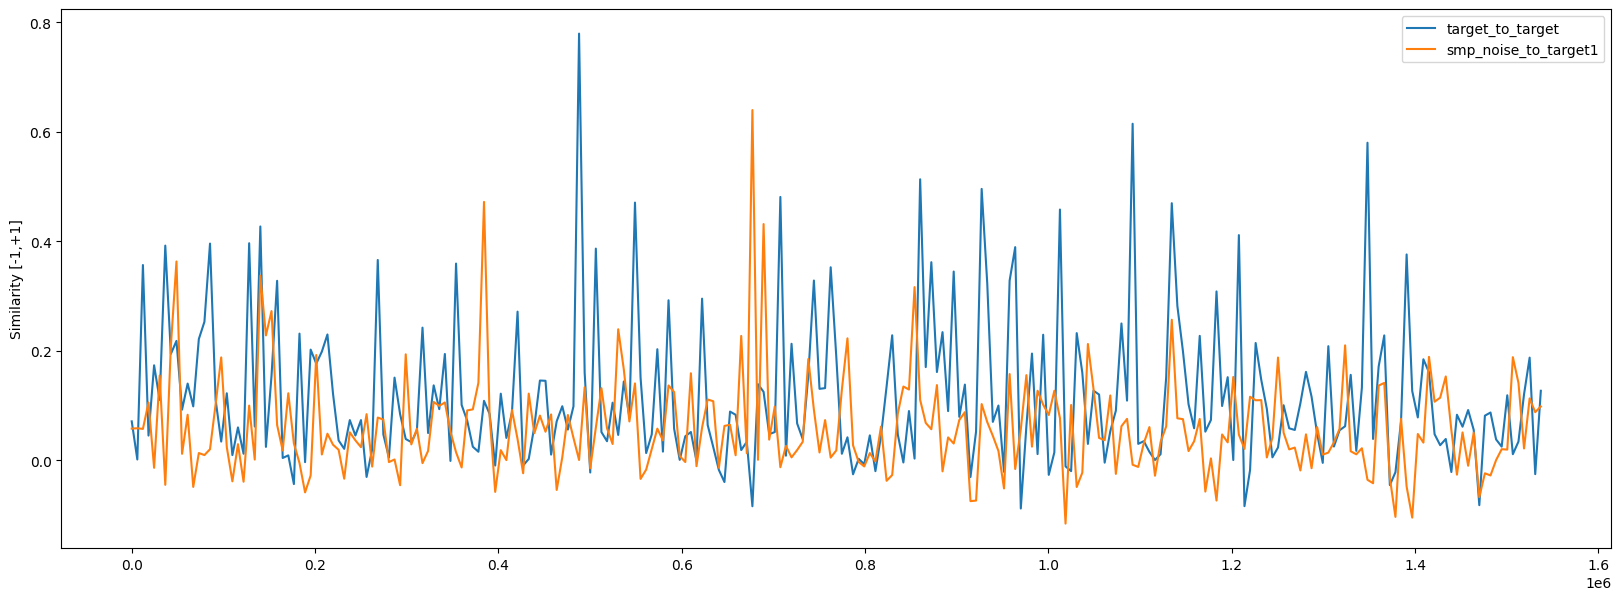

In [25]:
sample_step = 6100

plt.figure(figsize=(20,7))

line1 = [(idx, x) for idx, x in enumerate(target_to_target) if (idx % sample_step==0)]
line2 = [(idx, x) for idx, x in enumerate(target1_to_input) if (idx % sample_step==0)]
line3 = [(idx, x) for idx, x in enumerate(target2_to_input) if (idx % sample_step==0)]
line4 = [(idx, x) for idx, x in enumerate(smp_noise_to_input) if (idx % sample_step==0)]
line5 = [(idx, x) for idx, x in enumerate(smp_noise_to_target1) if (idx % sample_step==0)]

plt.plot([x[0] for x in line1], [x[1] for x in line1], label = "target_to_target")
#plt.plot([x[0] for x in line2], [x[1] for x in line2], label = "target1_to_input")
#plt.plot([x[0] for x in line3], [x[1] for x in line3], label = "target2_to_input")
#plt.plot([x[0] for x in line4], [x[1] for x in line4], label = "smp_noise_to_input")
plt.plot([x[0] for x in line5], [x[1] for x in line5], label = "smp_noise_to_target1")

plt.ylabel("Similarity [-1,+1]")
plt.legend()
plt.show()